How to clean the sts-test

sed -E -e 's/\t(Europe|StackExchange).*//' stsbenchmark/sts-test.csv > stsbenchmark/sts-test2.csv
Remove the " at in line 1118

In [2]:
import pandas as pd
import fasttext.util 
import similaritymeasures
import string
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
# sts_test = pd.read_csv('stsbenchmark/sts-train.csv', sep="\t", header=None, names=['genre', 'file', 'years', 'id', 'sim', 'sent1', 'sent2'])

# sts_test

In [4]:
sts_test = pd.read_csv('stsbenchmark/sts-test2.csv', sep="\t", header=None, names=['genre', 'file', 'years', 'id', 'sim', 'sent1', 'sent2'])

sts_test

,genre,file,years,id,sim,sent1,sent2
0,main-captions,MSRvid,2012test,24,2.5,A girl is styling her hair.,A girl is brushing her hair.
1,main-captions,MSRvid,2012test,33,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,main-captions,MSRvid,2012test,45,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,main-captions,MSRvid,2012test,63,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,main-captions,MSRvid,2012test,66,1.5,A man is playing a harp.,A man is playing a keyboard.
...,...,...,...,...,...,...,...
1373,main-news,headlines,2016,1354,0.0,"Philippines, Canada pledge to further boost re...",Philippines saves 100 after ferry sinks
1374,main-news,headlines,2016,1360,1.0,Israel bars Palestinians from Jerusalem's Old ...,"Two-state solution between Palestinians, Israe..."
1375,main-news,headlines,2016,1368,1.0,How much do you know about Secret Service?,Lawmakers from both sides express outrage at S...
1376,main-news,headlines,2016,1420,0.0,Obama Struggles to Soothe Saudi Fears As Iran ...,Myanmar Struggles to Finalize Voter Lists for ...


In [5]:
# make sent1 and sent2 lower
sts_test['sent1'] = sts_test['sent1'].str.lower()
sts_test['sent2'] = sts_test['sent2'].str.lower()

# remove punctuation
sts_test['sent1'] = sts_test['sent1'].apply(lambda x: str(x).translate(str.maketrans('', '', string.punctuation)))
sts_test['sent2'] = sts_test['sent2'].apply(lambda x: str(x).translate(str.maketrans('', '', string.punctuation)))

sts_test

,genre,file,years,id,sim,sent1,sent2
0,main-captions,MSRvid,2012test,24,2.5,a girl is styling her hair,a girl is brushing her hair
1,main-captions,MSRvid,2012test,33,3.6,a group of men play soccer on the beach,a group of boys are playing soccer on the beach
2,main-captions,MSRvid,2012test,45,5.0,one woman is measuring another womans ankle,a woman measures another womans ankle
3,main-captions,MSRvid,2012test,63,4.2,a man is cutting up a cucumber,a man is slicing a cucumber
4,main-captions,MSRvid,2012test,66,1.5,a man is playing a harp,a man is playing a keyboard
...,...,...,...,...,...,...,...
1373,main-news,headlines,2016,1354,0.0,philippines canada pledge to further boost rel...,philippines saves 100 after ferry sinks
1374,main-news,headlines,2016,1360,1.0,israel bars palestinians from jerusalems old city,twostate solution between palestinians israel ...
1375,main-news,headlines,2016,1368,1.0,how much do you know about secret service,lawmakers from both sides express outrage at s...
1376,main-news,headlines,2016,1420,0.0,obama struggles to soothe saudi fears as iran ...,myanmar struggles to finalize voter lists for ...


In [6]:
# drop null row
sts_test = sts_test.dropna()

In [7]:
# load fasttext model
ft = fasttext.load_model('cc.en.300.bin')

In [8]:
# create columns of word vectors
sts_test['sent1_wv'] = sts_test['sent1'].apply(lambda x: [ft.get_word_vector(word) for word in x.split()])
sts_test['sent2_wv'] = sts_test['sent2'].apply(lambda x: [ft.get_word_vector(word) for word in x.split()])

In [9]:
# find Frechet similarity
sts_test['frech_sim'] = sts_test.apply(lambda x: similaritymeasures.frechet_dist(x.sent1_wv, x.sent2_wv), axis=1)

In [10]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

sts_test['jaccard_sim'] = sts_test.apply(lambda x: get_jaccard_sim(x.sent1, x.sent2), axis=1)

In [11]:
# Doc2Vec
# data = sts_test['sent1'].append(sts_test['sent2'])

# tagged_data = [TaggedDocument(words=word_tokenize(str(_d).lower()), tags=[str(i)]) for i, _d in enumerate(data)]
# model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=2, epochs=80)
# model.build_vocab(tagged_data)
# model.train(tagged_data, total_examples=model.corpus_count, epochs=30)
# model.save("d2v_train.model")
model = Doc2Vec.load('d2v_train.model')

In [12]:
sts_test['sent1_d2v'] = sts_test['sent1'].apply(lambda x: model.infer_vector(word_tokenize(str(x).lower())))
sts_test['sent2_d2v'] = sts_test['sent2'].apply(lambda x: model.infer_vector(word_tokenize(str(x).lower())))

In [13]:
sts_test['d2v_similarity'] = sts_test.apply(lambda x: cosine_similarity([x.sent1_d2v, x.sent2_d2v])[0, 1], axis=1)

Text(0.5, 1.0, 'Sim Scores')

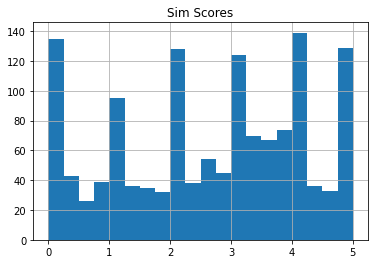

In [14]:
import matplotlib.pyplot as plt
sts_test['sim'].hist(bins=20)
plt.title("Sim Scores")

Text(0.5, 1.0, 'Frechet')

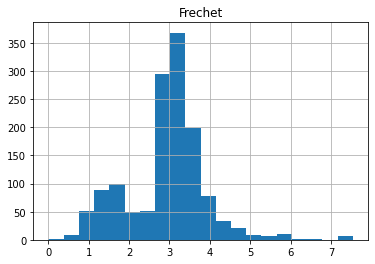

In [15]:
sts_test['frech_sim'].hist(bins=20)
plt.title('Frechet')

Text(0.5, 1.0, 'Jaccard')

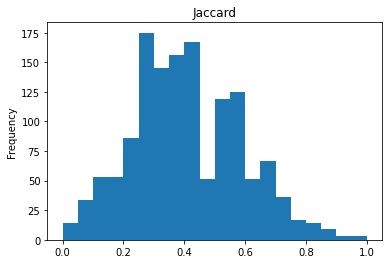

In [16]:
sts_test['jaccard_sim'].plot(kind='hist', bins=20)
plt.title("Jaccard")

Text(0.5, 1.0, 'Doc2Vec')

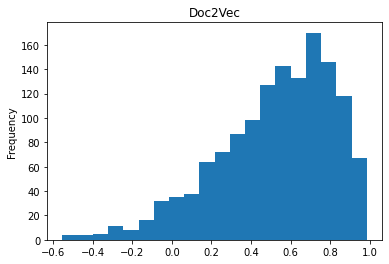

In [17]:
sts_test['d2v_similarity'].plot(kind='hist', bins=20)
plt.title("Doc2Vec")

In [18]:
sts_test['frech_sim'].mean()

2.9479357349367366

In [19]:
# print('sent1', sts_test[sts_test['frech_sim'] == sts_test['frech_sim'].min()]['sent1'])
# print('sent2', sts_test[sts_test['frech_sim'] == sts_test['frech_sim'].min()]['sent2'])
sts_test[sts_test['frech_sim'] == sts_test['frech_sim'].min()]

,genre,file,years,id,sim,sent1,sent2,sent1_wv,sent2_wv,frech_sim,jaccard_sim,sent1_d2v,sent2_d2v,d2v_similarity
623,main-captions,track5.en-en,2017,245,5.0,a brown dog is jumping,a brown dog is jumping,"[[0.08764305, -0.49590126, -0.04985499, -0.093...","[[0.08764305, -0.49590126, -0.04985499, -0.093...",0.0,1.0,"[0.011172764, -0.054539654, 0.08212706, 0.0004...","[0.037813764, 0.0014978914, 0.08167594, -0.007...",0.804256


In [20]:
# print('sent1', sts_test[sts_test['frech_sim'] == sts_test['frech_sim'].max()]['sent1'])
# print('sent2', sts_test[sts_test['frech_sim'] == sts_test['frech_sim'].max()]['sent2'])
sts_test[sts_test['frech_sim'] == sts_test['frech_sim'].max()]

,genre,file,years,id,sim,sent1,sent2,sent1_wv,sent2_wv,frech_sim,jaccard_sim,sent1_d2v,sent2_d2v,d2v_similarity
1321,main-news,headlines,2015,1123,4.8,croatia begins countdown to historic eu entry,croatia countdowns to joining eu,"[[0.0878931, -0.0021608775, -0.06860943, -0.00...","[[0.0878931, -0.0021608775, -0.06860943, -0.00...",7.541843,0.333333,"[-0.0180744, -0.2609982, 0.10777694, -0.077278...","[-0.010230944, -0.17719443, 0.07174636, -0.002...",0.844319


In [21]:
# False Positives: where the frechet similarity thinks they are similar but they are not
sts_test[(sts_test['frech_sim'] <= 1) & (sts_test['sim'] < 2)][['sent1', 'sent2', 'sim', 'frech_sim', 'jaccard_sim', 'd2v_similarity']]

,sent1,sent2,sim,frech_sim,jaccard_sim,d2v_similarity
9,a man is playing a guitar,a man is playing a trumpet,1.714,0.985250,0.666667,0.451241
10,a man is playing a guitar,a man is playing a trumpet,1.714,0.985250,0.666667,0.656975
12,a man is cycling,a man is talking,0.600,0.983160,0.600000,0.767749
15,a man is playing a guitar,a man is playing a keyboard,1.800,0.954951,0.666667,0.773195
28,a man is speaking,a man is cooking,0.800,0.903790,0.600000,0.880866
126,someone is drawing,someone is dancing,0.300,0.901419,0.500000,0.670550
149,a man is praying,a man is dancing,0.750,0.985135,0.600000,0.727697
157,a man is spitting,a man is talking,0.800,0.717959,0.600000,0.838156
159,a man is dancing,a man is thinking,1.200,0.857412,0.600000,0.521807
612,a group of kids are having a jumping contest,a group of kids are having a sleepover,1.200,0.983003,0.666667,0.637220


In [22]:
# False Negatives: where the frechet similarity thinks they are not similar but they are
sts_test[(sts_test['frech_sim'] >= 5) & (sts_test['sim'] >= 4)][['sent1', 'sent2', 'sim', 'frech_sim', 'jaccard_sim', 'd2v_similarity']]

,sent1,sent2,sim,frech_sim,jaccard_sim,d2v_similarity
768,well i wouldnt put it on my cv,i wouldnt put this job on my resume,4.0,5.657111,0.454545,0.673679
947,second comes hp 27 percent with 29 billion up ...,hp fell to second place with server sales grow...,4.4,6.330658,0.411765,0.850495
1298,georgian pms ally to become president exit poll,ally of georgias billionaire pm to be presiden...,4.6,5.704584,0.285714,0.571983
1321,croatia begins countdown to historic eu entry,croatia countdowns to joining eu,4.8,7.541843,0.333333,0.844319
1334,uks expremier margaret thatcher dies at 87,former british pm margaret thatcher dies,4.0,5.056745,0.300000,0.559227


In [23]:
sts_test[['sent1', 'sent2', 'sim', 'frech_sim', 'jaccard_sim', 'd2v_similarity']].head()

,sent1,sent2,sim,frech_sim,jaccard_sim,d2v_similarity
0,a girl is styling her hair,a girl is brushing her hair,2.5,0.958711,0.714286,0.963564
1,a group of men play soccer on the beach,a group of boys are playing soccer on the beach,3.6,1.857392,0.583333,0.740177
2,one woman is measuring another womans ankle,a woman measures another womans ankle,5.0,2.968911,0.444444,0.595884
3,a man is cutting up a cucumber,a man is slicing a cucumber,4.2,3.686892,0.571429,0.361798
4,a man is playing a harp,a man is playing a keyboard,1.5,1.533111,0.666667,0.621090
